# Media-Filter: 80/20 split, LSTM + MLP
- Split: 80% train, 20% test (stratified, random_state=333)
- The same 20% test set is passed as validation_data during training
- Time series: EFP (3 channels), EPP (1 channel) -> (T=50, 4)
- Additional features: predict1..predict50 -> MLP branch
- Test metrics + top errors

In [1]:
import os
import random
import struct
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    mean_squared_error, r2_score, accuracy_score, recall_score, 
    f1_score, roc_auc_score, classification_report, confusion_matrix
)

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Reproducibility
SEED = 333
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
try:
    tf.config.experimental.enable_op_determinism(True)
except Exception:
    pass

# Basic params and paths
TARGET_LEN = 50
DATA_DIR = '/kaggle/input/emotionlib-media-filter-dataset-extended-inter'
CSV_PATH = f'{DATA_DIR}/mlp-intermediate.csv'
BIN_DIR = f'{DATA_DIR}/Data'

print(f"TensorFlow: {tf.__version__}")

2025-10-03 13:02:24.825228: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759496545.033404      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759496545.095936      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TensorFlow: 2.18.0


## Load CSV and prepare target

In [2]:
data = pd.read_csv(CSV_PATH)

# Target: NC-17 -> 1 (Unsafe), others -> 0 (Safe)
class_mapping = {'G': 0, 'PG': 0, 'PG-13': 0, 'R': 0, 'NC-17': 1}
data['target'] = data['target'].map(class_mapping)

# Drop rows with missing key fields before merging
data = data.dropna(subset=['filename', 'target']).reset_index(drop=True)

print("CSV rows after initial dropna:", len(data))
print("Target distribution:\n", data['target'].value_counts())

CSV rows after initial dropna: 8279
Target distribution:
 target
0    6189
1    2090
Name: count, dtype: int64


## Read .epp/.efp and extract the centered window T=50

In [3]:
def read_epp_file(file_path):
    # .epp: int num_frames, int frame_sec_interval, per-frame 2 floats (take the 2nd: positiveness)
    with open(file_path, 'rb') as file:
        num_frames = struct.unpack('i', file.read(4))[0]
        frame_sec_interval = struct.unpack('i', file.read(4))[0]
        tensor_predictions = np.zeros(num_frames, dtype=np.float32)
        for i in range(num_frames):
            tensor_predictions[i] = struct.unpack('ff', file.read(8))[1]
    return num_frames, frame_sec_interval, tensor_predictions

def read_efp_file(file_path):
    # .efp: int num_frames, int frame_sec_interval, per-frame 3 floats
    with open(file_path, 'rb') as file:
        num_frames = struct.unpack('i', file.read(4))[0]
        frame_sec_interval = struct.unpack('i', file.read(4))[0]
        tensor_predictions = np.zeros((num_frames, 3), dtype=np.float32)
        for i in range(num_frames):
            tensor_predictions[i, :] = struct.unpack('fff', file.read(12))
    return num_frames, frame_sec_interval, tensor_predictions

def extract_center_elements(series, target_length=50, fill_value=-1.0):
    # Centered window of length target_length; symmetric padding with fill_value if shorter
    current_length = len(series)
    if current_length >= target_length:
        start = (current_length - target_length) // 2
        return series[start:start + target_length].astype(np.float32)
    else:
        padding = target_length - current_length
        left_pad = padding // 2
        right_pad = padding - left_pad
        return np.pad(series, (left_pad, right_pad), constant_values=fill_value).astype(np.float32)

def process_files_simple(base_dir, target_length=50):
    efp_data = []
    epp_data = []
    filenames = []

    for root, _, files in os.walk(base_dir):
        efp_files = {file for file in files if file.endswith('.efp')}
        epp_files = {file for file in files if file.endswith('.epp')}
        common_files = {file[:-4] for file in efp_files} & {file[:-4] for file in epp_files}

        for name in sorted(common_files):
            efp_path = os.path.join(root, f"{name}.efp")
            epp_path = os.path.join(root, f"{name}.epp")

            try:
                # EFP -> (num_frames, 3) -> center -> (T,3) -> flatten
                _, _, tensor_efp = read_efp_file(efp_path)
                efp_center = np.column_stack([
                    extract_center_elements(tensor_efp[:, c], target_length=target_length)
                    for c in range(3)
                ]).astype(np.float32)
                efp_data.append(efp_center.reshape(-1))

                # EPP -> (num_frames,) -> center -> (T,)
                _, _, tensor_epp = read_epp_file(epp_path)
                epp_center = extract_center_elements(tensor_epp, target_length=target_length).astype(np.float32)
                epp_data.append(epp_center)

                filenames.append(name)
            except Exception as e:
                print(f"[WARN] Skipping {name}: {e}")

    efp_columns = [f'efp-{t}-{c}' for t in range(target_length) for c in range(3)]
    epp_columns = [f'epp-{t}' for t in range(target_length)]

    efp_df = pd.DataFrame(efp_data, columns=efp_columns)
    epp_df = pd.DataFrame(epp_data, columns=epp_columns)
    efp_df['filename'] = filenames
    epp_df['filename'] = filenames
    return efp_df, epp_df

efp_df, epp_df = process_files_simple(BIN_DIR, target_length=TARGET_LEN)
print("EFP rows:", len(efp_df), "EPP rows:", len(epp_df))

EFP rows: 8279 EPP rows: 8279


## Merge CSV + EFP/EPP and prepare features

In [4]:
# Inner join on filename (only rows having both CSV and binaries)
df = data.merge(efp_df, on='filename', how='inner').merge(epp_df, on='filename', how='inner')

# predict1..predict50 from CSV
predict_cols = [f'predict{i}' for i in range(1, TARGET_LEN + 1)]
missing_predict = [c for c in predict_cols if c not in df.columns]
if missing_predict:
    raise ValueError(f"Missing prediction columns in CSV: {missing_predict}")

# Ensure dtypes
for c in predict_cols:
    df[c] = df[c].astype(np.float32)

# Drop rows with NaNs in critical columns
critical_cols = ['target', 'filename'] + predict_cols \
    + [f'efp-{t}-{c}' for t in range(TARGET_LEN) for c in range(3)] \
    + [f'epp-{t}' for t in range(TARGET_LEN)]
df = df.dropna(subset=critical_cols).reset_index(drop=True)

print("Rows after merging and cleaning:", len(df))
print("Target distribution after merge:\n", df['target'].value_counts())

Rows after merging and cleaning: 8267
Target distribution after merge:
 target
0    6178
1    2089
Name: count, dtype: int64


## 80/20 split

In [5]:
y_all = df['target'].astype(int).values
idx_all = np.arange(len(df))

idx_train, idx_test = train_test_split(
    idx_all,
    test_size=0.2,
    stratify=y_all,
    random_state=SEED,
    shuffle=True,
)

def split_df_by_indices(df, idx):
    return df.iloc[idx].reset_index(drop=True)

df_train = split_df_by_indices(df, idx_train)
df_test  = split_df_by_indices(df, idx_test)

print(f"Train: {len(df_train)}, Test/Val: {len(df_test)}")
print("Target train:\n", df_train['target'].value_counts())
print("Target test :\n", df_test['target'].value_counts())

Train: 6613, Test/Val: 1654
Target train:
 target
0    4942
1    1671
Name: count, dtype: int64
Target test :
 target
0    1236
1     418
Name: count, dtype: int64


## Build tensors for the model

In [6]:
efp_cols = [f'efp-{t}-{c}' for t in range(TARGET_LEN) for c in range(3)]
epp_cols = [f'epp-{t}' for t in range(TARGET_LEN)]

def make_model_inputs(df_slice):
    # combined_input: (N, 50, 4) = concat(EFP(3), EPP(1))
    efp_arr = df_slice[efp_cols].to_numpy(dtype=np.float32).reshape(-1, TARGET_LEN, 3)
    epp_arr = df_slice[epp_cols].to_numpy(dtype=np.float32).reshape(-1, TARGET_LEN, 1)
    combined = np.concatenate([efp_arr, epp_arr], axis=-1)

    # predict_input: (N, 50)
    pred_arr = df_slice[predict_cols].to_numpy(dtype=np.float32)

    # y and names
    y_arr = df_slice['target'].astype(int).to_numpy()
    names = df_slice['filename'].astype(str).to_numpy()

    return combined, pred_arr, y_arr, names

Xc_train, Xp_train, y_train, names_train = make_model_inputs(df_train)
Xc_test,  Xp_test,  y_test,  names_test  = make_model_inputs(df_test)

print("Shapes:")
print("combined train:", Xc_train.shape, "predict train:", Xp_train.shape)
print("combined test :", Xc_test.shape,  "predict test :", Xp_test.shape)

Shapes:
combined train: (6613, 50, 4) predict train: (6613, 50)
combined test : (1654, 50, 4) predict test : (1654, 50)


## Model: LSTM on sequences + MLP on predict-vector

In [7]:
# Class weights from train
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))
print("Class weights:", class_weights)

# Architecture
predict_input = layers.Input(shape=(TARGET_LEN,), name='predict_input')
combined_input = layers.Input(shape=(TARGET_LEN, 4), name='combined_input')

x_seq = layers.LSTM(64)(combined_input)
x = layers.Concatenate()([x_seq, predict_input])

x = layers.Dense(32, activation='tanh')(x)
x = layers.BatchNormalization()(x)

x = layers.Dense(16, activation='relu', kernel_initializer='he_normal')(x)
x = layers.BatchNormalization()(x)

output = layers.Dense(1, activation='sigmoid')(x)

model = models.Model(inputs=[combined_input, predict_input], outputs=output)
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)
model.summary()

# Callbacks (validation = test, intentional)
early_stopping = EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=100,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    mode='min',
    factor=0.5,
    patience=80,
    min_lr=1e-6,
    verbose=1
)

# Training: validation_data is the same test set (intentional leakage)
history = model.fit(
    [Xc_train, Xp_train], y_train,
    validation_data=([Xc_test, Xp_test], y_test),
    epochs=200,
    batch_size=128,
    class_weight=class_weights,
    callbacks=[early_stopping, reduce_lr],
    verbose=1,
    shuffle=True
)

Class weights: {0: 0.6690611088628086, 1: 1.978755236385398}


I0000 00:00:1759496633.894989      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ combined_input      │ (None, 50, 4)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 64)        │     17,664 │ combined_input[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ predict_input       │ (None, 50)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 114)       │          0 │ lstm[0][0],       │
│ (Concatenate)       │                   │            │ predict_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 32)        │      3,680 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 32)        │        128 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 16)        │        528 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16)        │         64 │ dense_1[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │         17 │ batch_normalizat… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 22,081 (86.25 KB)

 Trainable params: 21,985 (85.88 KB)

 Non-trainable params: 96 (384.00 B)

Epoch 1/200


2025-10-03 13:03:55.431325: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_17}}
I0000 00:00:1759496639.625535      57 cuda_dnn.cc:529] Loaded cuDNN version 90300


47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8524 - auc: 0.9191 - loss: 0.3228

2025-10-03 13:04:02.286610: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_16}}


52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.8607 - auc: 0.9258 - loss: 0.3088 - val_accuracy: 0.9329 - val_auc: 0.9756 - val_loss: 0.2427 - learning_rate: 0.0010
Epoch 2/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9620 - auc: 0.9884 - loss: 0.1322 - val_accuracy: 0.9474 - val_auc: 0.9821 - val_loss: 0.1768 - learning_rate: 0.0010
Epoch 3/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9655 - auc: 0.9891 - loss: 0.1225 - val_accuracy: 0.9522 - val_auc: 0.9847 - val_loss: 0.1460 - learning_rate: 0.0010
Epoch 4/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9655 - auc: 0.9892 - loss: 0.1186 - val_accuracy: 0.9462 - val_auc: 0.9859 - val_loss: 0.1389 - learning_rate: 0.0010
Epoch 5/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9653 - auc: 0.9895 - loss: 0.1159 - val_accuracy: 0.9498 - val_auc: 0.9872 - val_loss: 0.1318 - learning_rate: 0.0010
Epoch 6/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9650 - auc: 0.9900 - loss:

## Evaluation

In [8]:
print("\n--- Model Evaluation on TEST Set ---")
test_loss, test_acc, test_auc = model.evaluate([Xc_test, Xp_test], y_test, verbose=0)
print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f} | Test AUC: {test_auc:.4f}")

# Predictions
y_pred_proba = model.predict([Xc_test, Xp_test], verbose=0).reshape(-1)
threshold = 0.5
y_pred = (y_pred_proba >= threshold).astype(int)

# Regression-like metrics on probabilities
mse = mean_squared_error(y_test, y_pred_proba)
r2 = r2_score(y_test, y_pred_proba)
count_large_errors = np.sum(np.abs(y_test - y_pred_proba) > 0.3)

# Classification metrics
acc = accuracy_score(y_test, y_pred)
recall_unsafe = recall_score(y_test, y_pred, pos_label=1)
f1_unsafe = f1_score(y_test, y_pred, pos_label=1)
try:
    auc_val = roc_auc_score(y_test, y_pred_proba)
except ValueError as e:
    print("AUC error:", e)
    auc_val = float('nan')

print("\nRegression-like metrics (probabilities):")
print(f"MSE: {mse:.4f} | R2: {r2:.4f} | Errors > 0.3: {count_large_errors}")

print("\nClassification Metrics (threshold = 0.5):")
print(f"Accuracy: {acc:.4f}")
print(f"Recall (Unsafe=1): {recall_unsafe:.4f}")
print(f"F1 (Unsafe=1): {f1_unsafe:.4f}")
print(f"AUC-ROC: {auc_val:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Safe (0)', 'Unsafe (1)']))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)


--- Model Evaluation on TEST Set ---


2025-10-03 13:05:18.499460: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_16}}


Test Loss: 0.0862 | Test Accuracy: 0.9698 | Test AUC: 0.9928

Regression-like metrics (probabilities):
MSE: 0.0232 | R2: 0.8774 | Errors > 0.3: 84

Classification Metrics (threshold = 0.5):
Accuracy: 0.9698
Recall (Unsafe=1): 0.9426
F1 (Unsafe=1): 0.9403
AUC-ROC: 0.9934

Classification Report:
              precision    recall  f1-score   support

    Safe (0)       0.98      0.98      0.98      1236
  Unsafe (1)       0.94      0.94      0.94       418

    accuracy                           0.97      1654
   macro avg       0.96      0.96      0.96      1654
weighted avg       0.97      0.97      0.97      1654


Confusion Matrix:
[[1210   26]
 [  24  394]]


## Top-8 largest errors by |y - p|

In [9]:
errors = np.abs(y_test - y_pred_proba)
top_idx = np.argsort(errors)[-8:][::-1]

print("\nTop-8 errors by absolute probability difference (Test Set):")
for rank, i in enumerate(top_idx, 1):
    print(f"{rank}. name: {names_test[i]}, y_true: {y_test[i]}, y_pred_proba: {y_pred_proba[i]:.4f}, Error: {errors[i]:.4f}")


Top-8 errors by absolute probability difference (Test Set):
1. name: safeevidn5569, y_true: 0, y_pred_proba: 0.9981, Error: 0.9981
2. name: safeevidn2418, y_true: 0, y_pred_proba: 0.9967, Error: 0.9967
3. name: gorvidn517, y_true: 1, y_pred_proba: 0.0062, Error: 0.9938
4. name: safeevidn2593, y_true: 0, y_pred_proba: 0.9887, Error: 0.9887
5. name: gorvidn599, y_true: 1, y_pred_proba: 0.0128, Error: 0.9872
6. name: gorvidn215, y_true: 1, y_pred_proba: 0.0176, Error: 0.9824
7. name: gorvidn421, y_true: 1, y_pred_proba: 0.0235, Error: 0.9765
8. name: gorvidn586, y_true: 1, y_pred_proba: 0.0248, Error: 0.9752


## Training curves

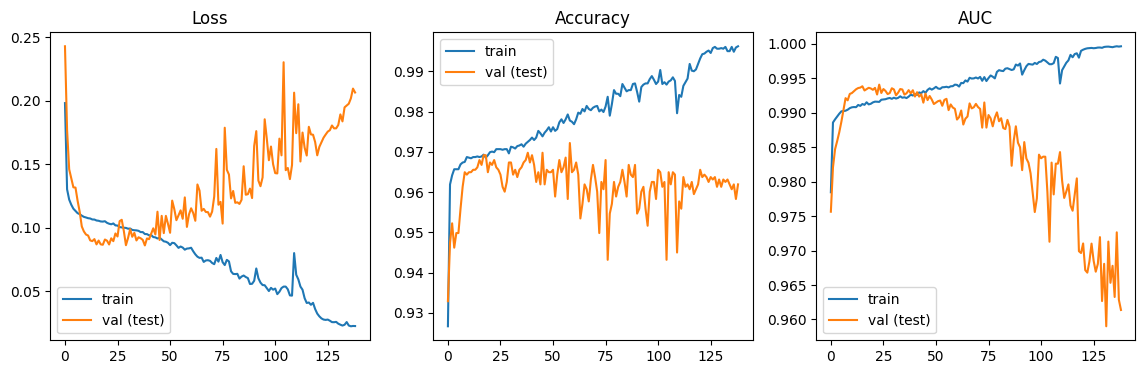

In [10]:
import matplotlib.pyplot as plt

hist = history.history
plt.figure(figsize=(14,4))

plt.subplot(1,3,1)
plt.plot(hist['loss'], label='train')
plt.plot(hist['val_loss'], label='val (test)')
plt.title('Loss'); plt.legend()

plt.subplot(1,3,2)
plt.plot(hist['accuracy'], label='train')
plt.plot(hist['val_accuracy'], label='val (test)')
plt.title('Accuracy'); plt.legend()

plt.subplot(1,3,3)
plt.plot(hist['auc'], label='train')
plt.plot(hist['val_auc'], label='val (test)')
plt.title('AUC'); plt.legend()

plt.show()